<a href="https://colab.research.google.com/github/cwlanyon/CardiacDTWorkshop/blob/main/EforCDC_Bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Emulators!

In this workbook we'll introduce AutoEmulate, a python package in development by the turing institute that finds the best emulator for your data!

https://www.autoemulate.com/

We'll be emulating a dataset generated by running the Reaction-eikonal model of electrophysiology over a personalised patient cardiac mesh, generated via CT imaging. You can learn more about the model and the patient meshes here: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008851



In [ ]:
!pip install AutoEmulate

In [ ]:
# Load important modules
# Support for maths
import numpy as np
import torch

import pandas as pd

from autoemulate.core.compare import AutoEmulate # emulators

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

# For splitting training and testing data
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Displaying images from URLs
from PIL import Image
from IPython.display import display
import urllib.request
from io import BytesIO

The Reaction-eikonal model simulates the propagation of electronic signals across the surface of the heart. In this example it was run over a personalised patient mesh from a cohort of meshes (see the figure below, we're using patient 1's cardiac mesh).

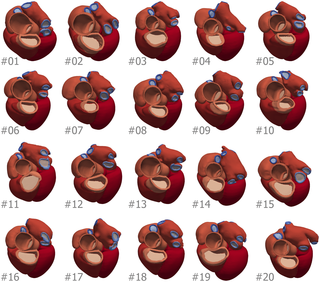

In [ ]:
# Figure showing customised cardiac meshes.

url = 'https://journals.plos.org/ploscompbiol/article/figure/image?size=inline&id=10.1371/journal.pcbi.1008851.g002'
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

First let's load the data from github.

In [ ]:
# Get data
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/X_EP.txt
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/Y.txt
# Get labels
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/ylabels.txt
!wget https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/xlabels_EP.txt



--2025-10-03 16:09:11--  https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/X_EP.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9227 (9.0K) [text/plain]
Saving to: ‘X_EP.txt.2’

X_EP.txt.2          100%[===================>]   9.01K  --.-KB/s    in 0s      

2025-10-03 16:09:11 (62.9 MB/s) - ‘X_EP.txt.2’ saved [9227/9227]

--2025-10-03 16:09:11--  https://raw.githubusercontent.com/cwlanyon/CardiacDTWorkshop/refs/heads/main/EP%20Data/Y.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2836

In [ ]:
#Read the data into DataFrame objects

x_labels=pd.read_csv('/content/xlabels_EP.txt',index_col=None,delim_whitespace=True,header=None)
y_labels=pd.read_csv('/content/ylabels.txt',index_col=None,delim_whitespace=True,header=None)

x_all = pd.read_csv('/content/X_EP.txt',index_col=None,delim_whitespace=True,header=None)
y_all = pd.read_csv('/content/Y.txt',index_col=None,delim_whitespace=True,header=None)

x_all.columns=x_labels.values.squeeze()
y_all.columns=y_labels.values.squeeze()

The model has 6 inputs, two conduction velocities (CV) and 4 anisotropy ratios which modify the CVs in different areas of the heart. Below we print the top of the input dataframe to show the parameters.

In [ ]:
x_all.head() # Show top 5 rows of input dataframe

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB
0,0.487005,0.321104,6.56834,0.799039,0.470510,5.04917
1,0.649337,0.345380,4.40605,0.311586,0.313059,4.37368
2,0.666146,0.431970,7.48917,0.996915,0.203510,3.88357
3,0.564330,0.319989,4.09474,0.680346,0.313557,3.05286
4,0.519419,0.363704,6.37449,0.538744,0.226915,2.15749


Though the model simulates electrical signals across the surface of the entire heart, we summarise the model using the "total activation time", the total time it takes for a signal to move across the surface. We calculate this quantity for the atria and the ventricles. This leads to two model outputs, $A_{TAT}$ and $V_{TAT}$.

In [ ]:
y_all.head() # show top 5 rows of output dataframe

,A_TAT,V_TAT
0,121.882,121.3370
1,344.083,90.1192
2,121.510,81.1778
3,165.531,106.5830
4,235.617,109.6840


To emulate the model using AutoEmulate we need to convert the dataframes into torch tensors with the float dtype.

In [ ]:
# Convert dataframe to torch tensor
x =  torch.tensor(x_all.values, dtype=torch.float32)
y = torch.tensor(y_all.values, dtype=torch.float32)

In [ ]:
# Use train_test_split to split into training and desting data
x_train, x_test, y_train, y_test = train_test_split(
    x, #inputs
    y, #outputs
    test_size=0.2, # proportion (or integer valued) of total data set used for testing
)

AutoEmulate automatically handles a lot of emulation decision making, it normalises the data, performs multiple train-test splits to test the robustness of the emulators to different training sets and creates output summaries. Below we generate an AutoEmulate object with our data.

In [ ]:
ae = AutoEmulate(x_train, y_train, log_level="error") # intialises autoemulate object





INFO:autoemulate:Comparing ['GaussianProcess', 'GaussianProcessCorrelated', 'GaussianProcessMatern32', 'GaussianProcessMatern52', 'GaussianProcessRBF', 'RadialBasisFunctions', 'RandomForest', 'PolynomialRegression', 'MLP', 'EnsembleMLP', 'EnsembleMLPDropout']
INFO:autoemulate:Running Model: GaussianProcess: 1/11 (attempt 1/3)
DEBUG:autoemulate:Running tuner for model "GaussianProcess"
DEBUG:autoemulate:Cross-validation parameters: KFold(n_splits=5, random_state=None, shuffle=True)
DEBUG:autoemulate:Cross-validation split 0: 92 train samples, 24 validation samples
DEBUG:autoemulate:Cross-validation split 1: 93 train samples, 23 validation samples
DEBUG:autoemulate:Cross-validation split 2: 93 train samples, 23 validation samples
DEBUG:autoemulate:Cross-validation split 3: 93 train samples, 23 validation samples
DEBUG:autoemulate:Cross-validation split 4: 93 train samples, 23 validation samples
DEBUG:autoemulate:tuning model: GaussianProcess; iteration: 1/10; mean (std) r2=0.918 (0.035);

In [ ]:
# Create summary list for each emulator
summary = [] # initialises empty array
for r in ae.results: # loops over all emulator runs
      emulator_results = [res for res in ae.results if res.model_name == r.model_name] # looks at all results for ONE emulator
      best_run = min(emulator_results, key=lambda res: res.rmse_test) # takes run with minimum rmse (best)
      summary.append((best_run.model_name, best_run.r2_test, best_run.rmse_test, best_run.model)) # adds best run to summary

In [ ]:
# Print Key results
for name, r2, rmse, model in summary:
    print(f"{name:25} R²={r2:.3f}, RMSE={rmse:.3f}")

GaussianProcess           R²=0.998, RMSE=1.763
GaussianProcessCorrelated R²=0.976, RMSE=5.542
GaussianProcessMatern32   R²=0.996, RMSE=3.120
GaussianProcessMatern52   R²=0.997, RMSE=2.945
GaussianProcessRBF        R²=0.998, RMSE=1.934
RadialBasisFunctions      R²=0.962, RMSE=6.626
RandomForest              R²=0.754, RMSE=22.902
PolynomialRegression      R²=0.976, RMSE=6.842
MLP                       R²=0.960, RMSE=7.399
EnsembleMLP               R²=0.742, RMSE=27.362
EnsembleMLPDropout        R²=0.935, RMSE=13.571


From the summary we can see that Gaussian process models are outperforming the other emulators, across several kernels. AutoEmulate also has a function to choose the best emulator for the training data, we use it below to predict the .

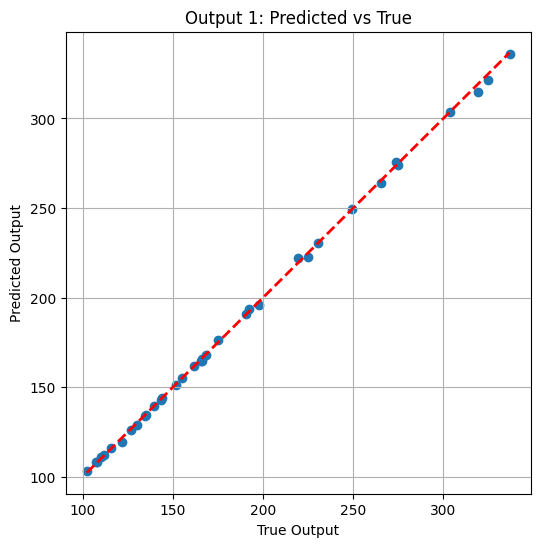

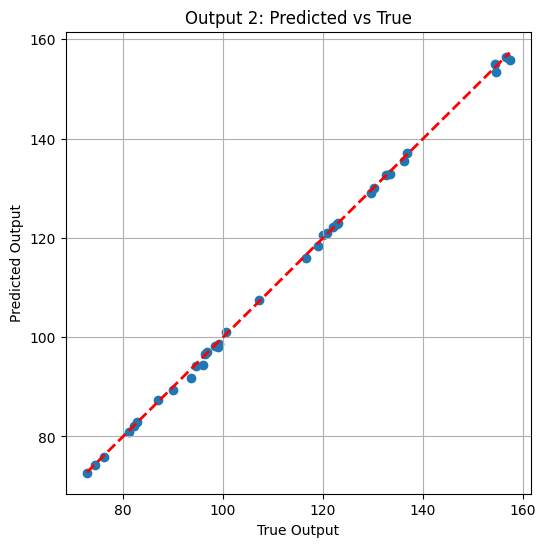

In [ ]:
# best model (chooses best emulator run over all emulator types)
best_result = ae.best_result()
best_model = best_result.model
y_pred = best_model.predict(x_test).mean

# --- Plot predicted vs true for each output dimension ---
y_true = y_test.detach().numpy() if isinstance(y, torch.Tensor) else y
n_outputs = y_true.shape[1]

for i in range(n_outputs):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true[:, i], y_pred[:, i])
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
             [y_true[:, i].min(), y_true[:, i].max()],
             'r--', lw=2)  # identity line
    plt.xlabel("True Output")
    plt.ylabel("Predicted Output")
    plt.title(f"Output {i+1}: Predicted vs True")
    plt.grid(True)
    plt.show()

# Bonus exercise

Use the autoemulate best emulator and SALib to generate sensitivity analysis for both outputs.